In [87]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os
import random
import csv
import time
import pickle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn import decomposition

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip, ImageSequenceClip

heatmap_arr = []
windows = []
windows_atScale = []
heatmap_filterSize = 8
cars_ar = []
frame_i = 0

In [79]:
class Car:
    def __init__(self):
        self.bboxAr = []
        self.bboxFilter = 6
        self.failedDetectCount = 0
        self.failedDetectThresh = 2
        self.curBboxArea = 0

    def bboxSize(self, bbox):
        xSize = bbox[1][0] - bbox[0][0]
        ySize = bbox[1][1] - bbox[0][1]
        return xSize*ySize

    def updatePos(self, bbox):
        if bbox == None:
            self.failedDetectCount += 1
            if self.failedDetectCount > self.failedDetectThresh:
                self.bboxAr = []
        else:
            self.failedDetectCount = 0
            # check if current position is much different
            if len(self.bboxAr):
                if (abs(bbox[0][0]-np.mean(self.bboxAr, axis=0).astype(int)[0][0])) > 100 or (abs(bbox[1][0]-np.mean(self.bboxAr, axis=0).astype(int)[1][0]) > 100):
                    self.bboxAr = []
            self.bboxAr.append(bbox)
            if len(self.bboxAr) > self.bboxFilter:
                self.bboxAr = self.bboxAr[1:]

    def getBbox(self):
        if self.bboxAr != []:
            # smooth bbox
            bbox = np.mean(self.bboxAr, axis=0).astype(int)
            self.curBboxArea = self.bboxSize(bbox)
            return bbox
            #return np.average(self.bboxAr)
        else:
            return None


In [80]:
# parameters for hog
orient = 9
pixels = (8,8)
cell_size = (2,2)

# short version of sklearn.feature.hog()
def hog_short(img, vis=False, feature_vector=True):
    if vis is True:
        features, hog_image = hog(img, orientations=9, cells_per_block=(2,2), 
                                  pixels_per_cell=(8,8), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vector)
        return features, hog_image
    
    else:
        features = hog(img, orientations=9, cells_per_block=(2,2), 
                       pixels_per_cell=(8,8), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector)
        return features
    
# a function to convert color space from BGR to cspace

# cspace = RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY

def convert_color(img, cspace):
    image = np.copy(img)
    
    constant_dict = {'RGB':cv2.COLOR_BGR2RGB, 
                     'HSV':cv2.COLOR_BGR2HSV, 
                     'LUV':cv2.COLOR_BGR2LUV,
                     'HLS':cv2.COLOR_BGR2HLS,
                     'YUV':cv2.COLOR_BGR2YUV,
                     'YCrCb':cv2.COLOR_BGR2YCR_CB,
                     'GRAY':cv2.COLOR_BGR2GRAY, 
                     'RGB2YCrCb':cv2.COLOR_RGB2YCR_CB, 
                     'BGR':cv2.COLOR_RGB2BGR}
    
    converted = cv2.cvtColor(image, constant_dict[cspace])
    
    return converted

In [81]:
# a function to iterate through training examples
 
# it takes pathnames as a list and returns hog feature vectors also as a list
# hog_channel = 0,1,2 or ALL

def hog_from_file(pathnames, hog_channel=[0,1,2], cspace='YCrCb', feature_vector=True):
    # Create a list to append feature vectors to
    all_features = []
    
    for image_path in pathnames:
        # read images one by one
        image = cv2.imread(image_path)
        # convert color space to desired one
        feat_img = convert_color(image, cspace)
            
        # extract features from single image
        
        features = []

        for channel in hog_channel:
            features.append(hog_short(feat_img[:,:,channel], feature_vector=feature_vector))

        features = np.ravel(features)

        # append features to return list
        all_features.append(np.concatenate((features)))
        
    return all_features

In [76]:
# takes images as a np.array / list of np.array's
def hog_from_list(imgs, hog_channel=[0,1,2], cspace='YCrCb', feature_vector=True):
    all_features = []
    
    for img in imgs:
        image = np.copy(img)
       
        # convert color space to desired one
        feat_img = convert_color(image, cspace)
        
        # extract features from single image
        features = []

        for channel in hog_channel:
            features.append(hog_short(feat_img[:,:,channel], feature_vector=feature_vector))

        features = np.ravel(features)

        # append features to return list
        all_features.append(features)
        
    return all_features

In [77]:
# takes images as a np.array / list of np.array's
def hog_from_list_gray(imgs, feature_vector=True):
    all_features = []
    
    for img in imgs:
        feat_img = np.copy(img)
        
        features = hog_short(feat_img)

        features = np.ravel(features)

        # append features to return list
        all_features.append(features)
        
    return all_features

In [62]:
# returns list of possible windows to be searched on image
def slide_window(img, x_start_stop=[0, None], y_start_stop=[0, None], 
                    windowSizeArr=[64], xy_overlap=(0.5, 0.5)):
    
    # If x and/or y stop positions not defined, set to image size
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Initialize a list to append window positions to
    window_list = []
    for windowSize in windowSizeArr:
        xy_window = (windowSize, windowSize)
        
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan / nx_pix_per_step) - 1
        ny_windows = np.int(yspan / ny_pix_per_step) - 1
        
        # Loop through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((int(startx), int(starty)), (int(endx), int(endy))))
    
    # Return the list of windows
    return window_list

In [63]:
# crops given windows positions from image, return as a list
def get_window_imgs(img, windows, outSize=64, resize=True):
    imgs = []
    for window in windows:
        if resize:
            imgs.append(cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64)))
        else:
            imgs.append(img[window[0][1]:window[1][1], window[0][0]:window[1][0]])
    imgs = np.array(imgs)
    return imgs

In [64]:
# takes colored (0,0,0) copy of image, adds heat(color intensity) to pixels in box_list
def add_heat(heatmap, box_list):
    # Iterate through list of boxes
    for box in box_list:
        
        # Add += 1 for all pixels inside each box
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [65]:
# applies threshold for eliminating false positive results
def apply_threshold(heatmap, threshold):
    # copy image
    th_heatmap = np.copy(heatmap)
    
    # Zero out pixels below the threshold
    th_heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return th_heatmap

In [66]:
# takes img and box positions, returns boxes drawn img
def draw_boxes(img, boxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    img_copy = np.copy(img)
    
    # Iterate through the bounding boxes
    for box in boxes:
        
        # Draw a rectangle given box coordinates
        cv2.rectangle(img_copy, box[0], box[1], color, thick)
    
    # Return the image copy with boxes drawn
    return img_copy

In [67]:
# takes original image and labeled heatmap tuple, returns labeled box img
def draw_labeled_boxes(image, labels):
    # Copy image
    img = np.copy(image)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
        cv2.rectangle(img,(box[0][0],box[0][1]-20),(box[0][0]+100,box[0][1]),(125,125,125),-1)
        cv2.putText(img, 'car {}'.format(car_number),(box[0][0]+5,box[0][1]-2),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0), thickness=2)
    
    # Return the image
    return img

In [68]:
def draw_labeled_car_boxes(img, cars):
    # Iterate through all detected cars
    for car_number in range(len(cars)):
        bbox = cars[car_number].getBbox()
        if bbox != None:
            cv2.rectangle(img, (bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1]), (0,0,255), 6)
    # Return the image
    return img

In [69]:
def process_img(img, svc, X_scaler, pca, windows, threshold=1):
    # create heatmap
    heat = np.zeros_like(img[:,:,0].astype(np.float))
    
    # get img patches from frame and extract features
    patches = get_window_imgs(img, windows)
    features = hog_from_list(patches)
        
    # normalize and predict
    X = np.vstack((features)).astype(np.float64)
    scaled_X = X_scaler.transform(X)
    scaled_X = pca.transform(scaled_X)
    pred_bin = svc.predict(scaled_X[:])
    
    # positive positions
    indices = [x for x in range(len(pred_bin)) if pred_bin[x]==1]
    hot_windows = [windows[i] for i in indices]
    
    # draw boxes and heatmap
    # window_img includes all boxes
    # heatmap must shown with cmap='heat'
    # label_img includes generalized boxes only
    img = convert_color(img, 'RGB')
    window_img = draw_boxes(img, hot_windows)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    label_img = draw_labeled_boxes(img, labels)
    
    return window_img, label_img, heatmap

In [70]:
def process_imgs(imgs, svc, X_scaler, pca, threshold=1, 
                 windowSizes=[96, 128, 145], windowOverlap=0.75):
    window_imgs = []
    label_imgs = []
    heatmaps = []
    
    # sample img for window positions and sample heatmap
    sample = imgs[0]
    
    # declare x/y start stop positions
    x_start_stop=[0, sample.shape[1]]
    y_start_stop=[int(sample.shape[0]/2), sample.shape[0] - 32]
    
    # extract window positions
    windows = slide_window(sample, 
                           x_start_stop=x_start_stop, 
                           y_start_stop=y_start_stop,
                           windowSizeArr=windowSizes, 
                           xy_overlap=(windowOverlap, windowOverlap))
    
    
    # start processing and stack results on seperate lists
    for img in imgs:
        window_img, label_img, heatmap = process_img(img, 
                                                     svc=svc, 
                                                     X_scaler=X_scaler,
                                                     pca=pca, 
                                                     windows=windows, 
                                                     threshold=threshold)
        window_imgs.append(window_img)
        label_imgs.append(label_img)
        heatmaps.append(heatmaps)
    
    return window_imgs, label_imgs, heatmaps

In [71]:
svc = joblib.load('pickles/svm_gray.pkl')
X_scaler = joblib.load('pickles/svm_scaler_gray.pkl')
pca = joblib.load('pickles/svm_pca_gray.pkl')

def process_frame(img, svc=svc, X_scaler=X_scaler, pca=pca, imgScales=[1.0, 0.8, 0.65, 0.45], windowOverlap=0.8,debug=False):
    total_start = time.time()
    # sliding windows creation
    global heatmap_arr
    global windows
    global windows_atScale
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img_size = img.shape
    imgs = []
    
    imgCvt = convert_color(img, 'GRAY')

    factor_i = 0
    for scaleFac in imgScales:
         
        
        inverseFac = 1/scaleFac
        x_scaled = int(img_size[1]*scaleFac) #576
        y_scaled = int(img_size[0]*scaleFac) #324
        img_scaled = cv2.resize(imgCvt, (x_scaled, y_scaled))
        img_scaled_size = img_scaled.shape

        #if len(windows_atScale) != len(imgScales):
            #x_start_stop = [int(img_scaled_size[1]/2), img_scaled_size[1]]
            #y_start = int(img_scaled_size[0]/2)+int(30*scaleFac)
            #y_stop = (img_scaled_size[0]-int(100*scaleFac))
                
            # allow windowsizes of different scales in areas that make sense in the image plane
            #imgScales = [1., 0.8, 0.65, 0.45]
            #if factor_i == 0:
            #    x_start_stop = [640, 1090]
                #y_start = 417
                #y_stop = 447
            #elif factor_i == 1:
            #    x_start_stop = [512, 900]
            #    y_start = 325
            #    y_stop = 370
            #elif factor_i == 2:
            #    y_start = 265
            #    y_stop = 360
               
            
        start_stops = {0:((640,1090), (417,447)), 
                       1:((512,900), (325,370)), 
                       2:((416,832), (265,360)), 
                       3:((288,576), (175,279))}
            
        x_start_stop = start_stops[factor_i][0]
        y_start_stop = start_stops[factor_i][1]
            
        
        
        windows_atScale.append(slide_window(img_scaled, x_start_stop=x_start_stop, 
                                                y_start_stop=y_start_stop, windowSizeArr=[64], 
                                                xy_overlap=(windowOverlap, windowOverlap)))
        
        
        # save bounding box in original image space
        
        for each in windows_atScale[factor_i]:
            windows.append(((int(each[0][0]*inverseFac), int(each[0][1]*inverseFac)), 
                                (int(each[1][0]*inverseFac), int(each[1][1]*inverseFac))))
        
        #if debug:
        #    print('extracting windows at scale...')
        
        
        imgs.extend(get_window_imgs(img_scaled, windows_atScale[factor_i], resize=True))
        factor_i += 1

    # awkward: setting colorspace to BGR to circumvent cvtColor call
    t1 = time.time()
    features = hog_from_list_gray(imgs)
    X = np.vstack((features)).astype(np.float64)
    t2 = time.time()
    print('hog_from_list time')
    print(t2-t1)
    
    t1 = time.time()
    scaled_X = X_scaler.transform(X)
    t2 = time.time()
    print('X_scaler time')
    print(t2-t1)
    
    t1 = time.time()
    scaled_X = pca.transform(scaled_X)
    t2 = time.time()
    print('pca transform time')
    print(t2-t1)
    
    
    t1 = time.time()
    pred_bin = svc.predict(scaled_X)
    t2 = time.time()
    print('svc prediction time')
    print(t2-t1)
    
    t1 = time.time()
    ind = [x for x in range(len(pred_bin)) if pred_bin[x]==1]
    hot_windows = [windows[i] for i in ind]
    t2 = time.time()
    print('extracting hot_windows time')
    print(t2-t1)
    
    t1 = time.time()
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    t2 = time.time()
    print('add_heat time')
    print(t2-t1)
    
    t1 = time.time()
    # Apply threshold to help remove false positives for current frame
    heat = apply_threshold(heat, 2)
    #heatmap_arr.append(heat)
    #if len(heatmap_arr) > heatmap_filterSize:
    #    heatmap_arr = heatmap_arr[1:]
    #heat_combined = np.zeros_like(img[:,:,0]).astype(np.float)
    
    #for i in range(len(heatmap_arr)):
    #    heat_combined = heat_combined + heatmap_arr[i]
    #heat_combined = apply_threshold(heat_combined,5)
    
    # Visualize the heatmap when displaying
    #heatmap = np.clip(heat_combined, 0, 255)
    heatmap = np.clip(heat, 0, 255)
    t2 = time.time()
    print('heat and clip time')
    print(t2-t1)
    t1 = time.time()
    labels = label(heatmap)
    t2 = time.time()
    print('label time')
    print(t2-t1)
    
    total_stop = time.time()
    
    print('TOTAL TIME: ')
    print(total_stop - total_start)
    return heatmap, labels, hot_windows

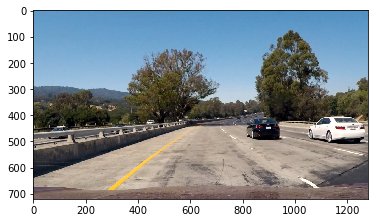

convert_color time
0.0
image resizing calculations for --- 0
0.0
extract sliding windows positions for ---- 0
0.0
adding scaled windows to general windows list for ---- 0
0.0
get_window_imgs and add to imgs list for ---- 0
0.0
image resizing calculations for --- 1
0.002500772476196289
extract sliding windows positions for ---- 1
0.0
adding scaled windows to general windows list for ---- 1
0.0
get_window_imgs and add to imgs list for ---- 1
0.0
image resizing calculations for --- 2
0.0
extract sliding windows positions for ---- 2
0.015624523162841797
adding scaled windows to general windows list for ---- 2
0.0
get_window_imgs and add to imgs list for ---- 2
0.0
image resizing calculations for --- 3
0.0
extract sliding windows positions for ---- 3
0.0005006790161132812
adding scaled windows to general windows list for ---- 3
0.0004999637603759766
get_window_imgs and add to imgs list for ---- 3
0.0030012130737304688
hog_from_list time
0.8078794479370117
X_scaler time
0.009505987167358398


In [72]:
test = cv2.imread('test_images/test1.jpg')
test = convert_color(test, 'RGB')
plt.imshow(test)
plt.show()
h, l, w = process_frame(test)

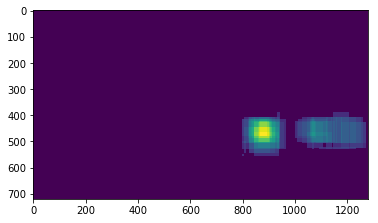

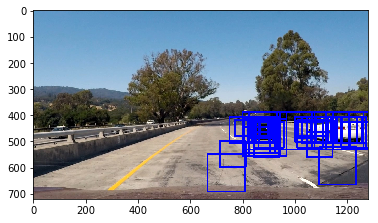

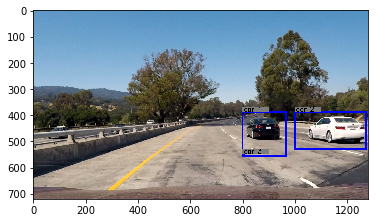

In [73]:
plt.imshow(h)
plt.show()
wind_im = draw_boxes(test, w)
plt.imshow(wind_im)
plt.show()
lab_im = draw_labeled_boxes(test, l)
plt.imshow(lab_im)
plt.show()

In [75]:
def process_vidFrame(img, outputDebug=False, boxOnlyOutput=False):
    global frame_i
    global cars_ar
    frame_i += 1
    t1 = time.time()
    heatmap, labels, hot_windows = process_frame(img)
    t2 = time.time()
    print('process_frame')
    print(t2-t1)
    
    t1 = time.time()
    for car_number in range(1, max(len(cars_ar), labels[1])+1):
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if len(nonzerox):
            # cut off tiny bounding boxes
            if ((max(nonzerox) - min(nonzerox)) / (max(nonzeroy) - min(nonzeroy))) > 0.65:
                # Define a bounding box based on min/max x and y
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            else:
                bbox = None
        else:
            bbox = None
        if len(cars_ar) < car_number:
            cars_ar.append(Car())
        cars_ar[car_number-1].updatePos(bbox)
    t2 = time.time()
    print('for loop')
    print(t2-t1)
    t1 = time.time()
    #label_img = vehicleUtil.draw_labeled_bboxes(np.copy(img), labels)
    label_img = draw_labeled_car_boxes(np.copy(img), cars_ar)
    t2 = time.time()
    print('label_img creation draw_labeled_car_boxes')
    print(t2-t1)
    if outputDebug:
        imgSize = (720, 1280 , 3)
        out_img = np.zeros(imgSize, dtype=np.uint8)

        smallFinal = cv2.resize(label_img, (0,0), fx=0.5, fy=0.5)
        smallFinalSize = (smallFinal.shape[1], smallFinal.shape[0])
        out_img[0:smallFinalSize[1], 0:smallFinalSize[0]] = smallFinal

        heatmap = heatmap*(255/8)
        heatmap = np.clip(heatmap, 0, 255)
        heatmap = np.dstack((heatmap, heatmap, heatmap))
        smallHeat = cv2.resize(heatmap, (0,0), fx=0.5, fy=0.5)
        smallHeatSize = (smallHeat.shape[1], smallHeat.shape[0])
        out_img[0:smallHeatSize[1], smallFinalSize[0]:smallFinalSize[0]+smallHeatSize[0]] = smallHeat

        window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
        rawWindows = cv2.resize(window_img, (0,0), fx=0.5, fy=0.5)
        rawWindowsSize = (rawWindows.shape[1], rawWindows.shape[0])
        out_img[smallFinalSize[1]:smallFinalSize[1]+rawWindowsSize[1], smallFinalSize[0]:smallFinalSize[0]+rawWindowsSize[0]] = rawWindows
    else:
        t1 = time.time()
        window_img = draw_boxes(img, hot_windows)
        t2 = time.time()
        print('window_img creation draw_boxes')
        print(t2-t1)
        out_img = label_img#convert_color(window_img, 'RGB')
    
    if boxOnlyOutput:
        return cars_ar
    return out_img

In [91]:
# GLOBALS
heatmap_arr = []
windows = []
windows_atScale = []
heatmap_filterSize = 8
cars_ar = []
frame_i = 0

file = 'test_video.mp4'
clip = VideoFileClip(file)

proc_clip = clip.fl_image(process_vidFrame)
proc_output = '{}_proc_svm_l.mp4'.format(file.split('.')[0])
proc_clip.write_videofile(proc_output, audio=False)

process_frame
2.084543466567993
for loop
0.03902769088745117
label_img creation draw_labeled_car_boxes
0.0025014877319335938
window_img creation draw_boxes
0.004001140594482422
[MoviePy] >>>> Building video test_video_proc_svm_l.mp4
[MoviePy] Writing video test_video_proc_svm_l.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

process_frame
2.112095594406128
for loop
0.03852581977844238
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.015636682510375977


  3%|██▏                                                                                | 1/39 [00:02<01:22,  2.18s/it]

process_frame
2.0922670364379883
for loop
0.044530630111694336
label_img creation draw_labeled_car_boxes
0.002001523971557617
window_img creation draw_boxes
0.0025010108947753906


  5%|████▎                                                                              | 2/39 [00:04<01:20,  2.18s/it]

process_frame
1.946864128112793
for loop
0.0430295467376709
label_img creation draw_labeled_car_boxes
0.002001523971557617
window_img creation draw_boxes
0.0035016536712646484


  8%|██████▍                                                                            | 3/39 [00:06<01:16,  2.14s/it]

process_frame
1.9539055824279785
for loop
0.047649383544921875
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 10%|████████▌                                                                          | 4/39 [00:08<01:13,  2.11s/it]

process_frame
1.988278865814209
for loop
0.04803824424743652
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 13%|██████████▋                                                                        | 5/39 [00:10<01:11,  2.10s/it]

process_frame
1.9864578247070312
for loop
0.0500335693359375
label_img creation draw_labeled_car_boxes
0.0014986991882324219
window_img creation draw_boxes
0.0035016536712646484


 15%|████████████▊                                                                      | 6/39 [00:12<01:09,  2.09s/it]

process_frame
2.014071226119995
for loop
0.03702592849731445
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.016017436981201172


 18%|██████████████▉                                                                    | 7/39 [00:14<01:06,  2.09s/it]

process_frame
2.198543071746826
for loop
0.04753232002258301
label_img creation draw_labeled_car_boxes
0.0020008087158203125
window_img creation draw_boxes
0.0030019283294677734


 21%|█████████████████                                                                  | 8/39 [00:16<01:06,  2.15s/it]

process_frame
1.9565250873565674
for loop
0.04502987861633301
label_img creation draw_labeled_car_boxes
0.002509593963623047
window_img creation draw_boxes
0.0030014514923095703


 23%|███████████████████▏                                                               | 9/39 [00:19<01:03,  2.12s/it]

process_frame
2.418884038925171
for loop
0.0468754768371582
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 26%|█████████████████████                                                             | 10/39 [00:21<01:05,  2.24s/it]

process_frame
2.15765118598938
for loop
0.03902626037597656
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.015634536743164062


 28%|███████████████████████▏                                                          | 11/39 [00:23<01:02,  2.24s/it]

process_frame
2.171116590499878
for loop
0.04252791404724121
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 31%|█████████████████████████▏                                                        | 12/39 [00:26<01:00,  2.25s/it]

process_frame
2.1498446464538574
for loop
0.037259578704833984
label_img creation draw_labeled_car_boxes
0.015692472457885742
window_img creation draw_boxes
0.0


 33%|███████████████████████████▎                                                      | 13/39 [00:28<00:58,  2.24s/it]

process_frame
1.9736089706420898
for loop
0.041527748107910156
label_img creation draw_labeled_car_boxes
0.0020012855529785156
window_img creation draw_boxes
0.003002166748046875


 36%|█████████████████████████████▍                                                    | 14/39 [00:30<00:54,  2.19s/it]

process_frame
2.276498556137085
for loop
0.05904102325439453
label_img creation draw_labeled_car_boxes
0.0015003681182861328
window_img creation draw_boxes
0.003502368927001953


 38%|███████████████████████████████▌                                                  | 15/39 [00:32<00:53,  2.25s/it]

process_frame
2.5413455963134766
for loop
0.05904102325439453
label_img creation draw_labeled_car_boxes
0.0020012855529785156
window_img creation draw_boxes
0.0030014514923095703


 41%|█████████████████████████████████▋                                                | 16/39 [00:35<00:54,  2.37s/it]

process_frame
2.7828545570373535
for loop
0.06604623794555664
label_img creation draw_labeled_car_boxes
0.003002166748046875
window_img creation draw_boxes
0.003001689910888672


 44%|███████████████████████████████████▋                                              | 17/39 [00:38<00:55,  2.53s/it]

process_frame
2.5156662464141846
for loop
0.062042951583862305
label_img creation draw_labeled_car_boxes
0.0020012855529785156
window_img creation draw_boxes
0.0030007362365722656


 46%|█████████████████████████████████████▊                                            | 18/39 [00:40<00:53,  2.56s/it]

process_frame
2.7577056884765625
for loop
0.0715491771697998
label_img creation draw_labeled_car_boxes
0.002501249313354492
window_img creation draw_boxes
0.003000974655151367


 49%|███████████████████████████████████████▉                                          | 19/39 [00:43<00:53,  2.65s/it]

process_frame
2.6453325748443604
for loop
0.06404471397399902
label_img creation draw_labeled_car_boxes
0.002501964569091797
window_img creation draw_boxes
0.0035016536712646484


 51%|██████████████████████████████████████████                                        | 20/39 [00:46<00:51,  2.68s/it]

process_frame
2.570822238922119
for loop
0.06054234504699707
label_img creation draw_labeled_car_boxes
0.0020008087158203125
window_img creation draw_boxes
0.003002166748046875


 54%|████████████████████████████████████████████▏                                     | 21/39 [00:49<00:48,  2.68s/it]

process_frame
2.351860523223877
for loop
0.04653120040893555
label_img creation draw_labeled_car_boxes
0.0020008087158203125
window_img creation draw_boxes
0.0035009384155273438


 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:51<00:44,  2.61s/it]

process_frame
2.9917805194854736
for loop
0.05153489112854004
label_img creation draw_labeled_car_boxes
0.0020017623901367188
window_img creation draw_boxes
0.0030012130737304688


 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:54<00:44,  2.76s/it]

process_frame
2.424360513687134
for loop
0.05303621292114258
label_img creation draw_labeled_car_boxes
0.0025017261505126953
window_img creation draw_boxes
0.0034987926483154297


 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:57<00:40,  2.69s/it]

process_frame
2.859933853149414
for loop
0.04152941703796387
label_img creation draw_labeled_car_boxes
0.002501249313354492
window_img creation draw_boxes
0.0025022029876708984


 64%|████████████████████████████████████████████████████▌                             | 25/39 [01:00<00:38,  2.77s/it]

process_frame
2.0382637977600098
for loop
0.0377659797668457
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [01:02<00:33,  2.57s/it]

process_frame
2.2681803703308105
for loop
0.030519962310791016
label_img creation draw_labeled_car_boxes
0.002001523971557617
window_img creation draw_boxes
0.002501249313354492


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [01:04<00:30,  2.50s/it]

process_frame
2.5246291160583496
for loop
0.0312504768371582
label_img creation draw_labeled_car_boxes
0.0020017623901367188
window_img creation draw_boxes
0.0


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [01:07<00:27,  2.53s/it]

process_frame
2.193978786468506
for loop
0.037259817123413086
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.0


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [01:09<00:24,  2.46s/it]

process_frame
1.990088701248169
for loop
0.03502368927001953
label_img creation draw_labeled_car_boxes
0.0010018348693847656
window_img creation draw_boxes
0.0


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [01:11<00:21,  2.34s/it]

process_frame
2.203598976135254
for loop
0.0468754768371582
label_img creation draw_labeled_car_boxes
0.0
window_img creation draw_boxes
0.017132997512817383


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [01:13<00:18,  2.32s/it]

process_frame
1.9946088790893555
for loop
0.03602433204650879
label_img creation draw_labeled_car_boxes
0.002000093460083008
window_img creation draw_boxes
0.003502368927001953


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [01:16<00:15,  2.25s/it]

process_frame
2.1043903827667236
for loop
0.04452800750732422
label_img creation draw_labeled_car_boxes
0.0020003318786621094
window_img creation draw_boxes
0.00250244140625


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [01:18<00:13,  2.24s/it]

process_frame
2.0192980766296387
for loop
0.03452348709106445
label_img creation draw_labeled_car_boxes
0.015628814697265625
window_img creation draw_boxes
0.0


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [01:20<00:10,  2.20s/it]

process_frame
2.0023577213287354
for loop
0.047533273696899414
label_img creation draw_labeled_car_boxes
0.002502918243408203
window_img creation draw_boxes
0.003502368927001953


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [01:22<00:08,  2.17s/it]

process_frame
2.0876271724700928
for loop
0.04753398895263672
label_img creation draw_labeled_car_boxes
0.004501819610595703
window_img creation draw_boxes
0.003502368927001953


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [01:24<00:06,  2.17s/it]

process_frame
2.1517796516418457
for loop
0.0455322265625
label_img creation draw_labeled_car_boxes
0.0020008087158203125
window_img creation draw_boxes
0.0025014877319335938


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [01:26<00:04,  2.19s/it]

process_frame
2.1613621711730957
for loop
0.05338644981384277
label_img creation draw_labeled_car_boxes
0.015626907348632812
window_img creation draw_boxes
0.0


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:29<00:02,  2.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_proc_svm_l.mp4 



In [122]:
#heatmap, labels, hot_windows = process_frame(img, svc, X_scaler, pca)

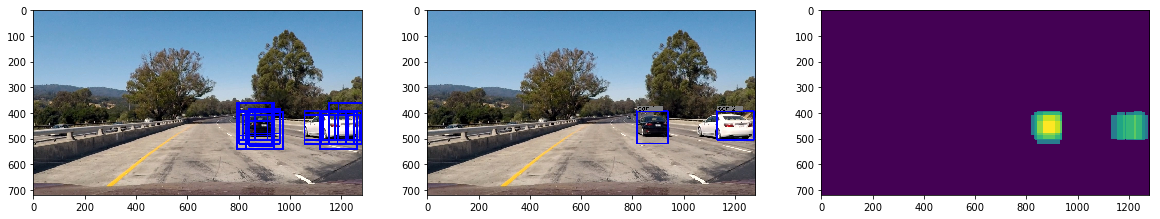

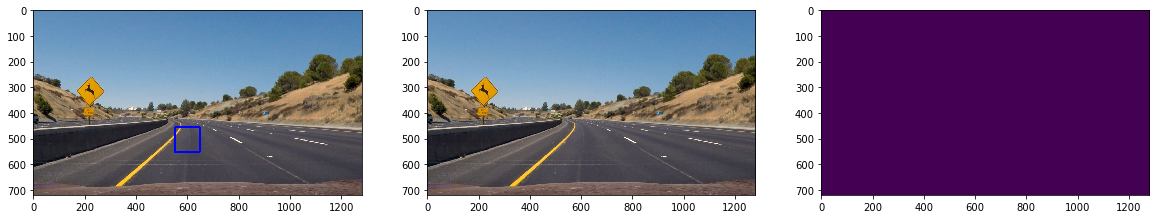

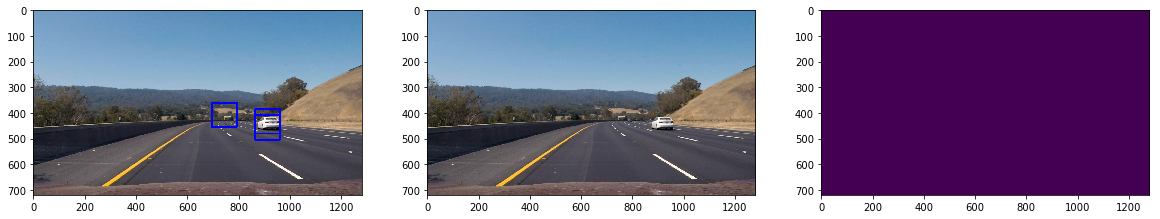

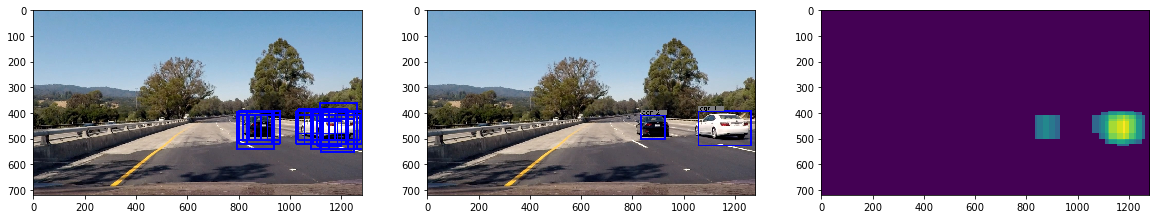

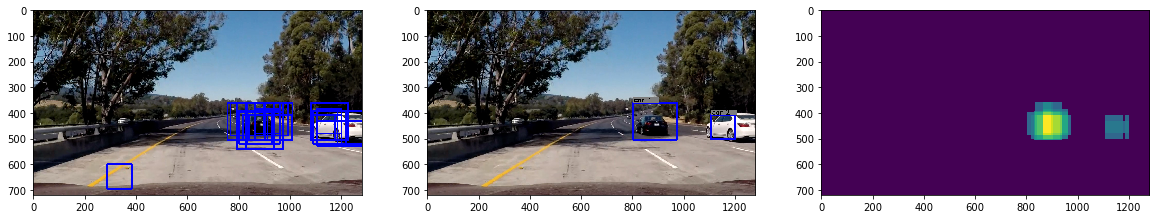

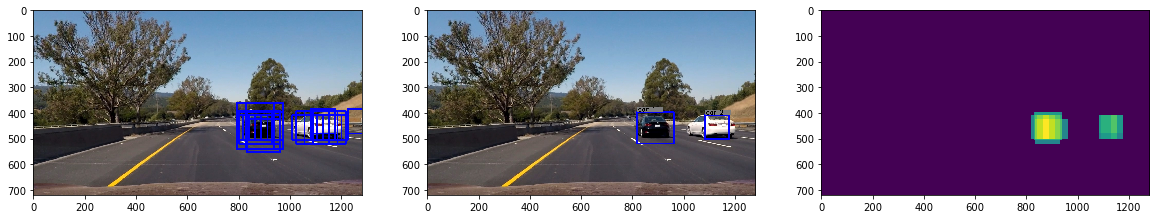

In [25]:
#test_imgs = glob.glob('test_images/*.jpg', recursive=True)

#for file in test_imgs:
#    img = cv2.imread(file)
#    ws, ls, hs = process_img(img, svc, X_scaler, pca, windows, threshold=4)
#    fig = plt.figure(figsize=(20,10))
#    plt.subplot(131)
#    plt.imshow(ws)
#    plt.subplot(132)
#    plt.imshow(ls)
#    plt.subplot(133)
#    plt.imshow(hs)
#    plt.show()

In [84]:
q = '''
windowOverlap = 0.75
windowSizes = [96, 128, 145]

svc = joblib.load('pickles/svm.pkl')
X_scaler = joblib.load('pickles/svm_scaler.pkl')
pca = joblib.load('pickles/svm_pca.pkl')


img = cv2.imread('test_images/test1.jpg')
img_size = img.shape
x_start_stop = [0, img_size[1]]
y_start_stop = [int(img_size[0]/2), img_size[0]-32]

windows = slide_window(img, 
                       x_start_stop=[0, None], 
                       y_start_stop=y_start_stop, 
                       windowSizeArr=windowSizes, 
                       xy_overlap=(windowOverlap, windowOverlap))
'''
start_stops = {0:((640,1090))}

In [86]:
im = cv2.imread('test_images/test1.jpg')
im.shape

(720, 1280, 3)

In [ ]:
imgScales = [1.0, 0.8, 0.65, 0.45]

for scaleFac in imgScales:
    inverseFac = 1/scaleFac
    x_scaled = int(img_size[1]*scaleFac) #576
    y_scaled = int(img_size[0]*scaleFac) #324
    img_scaled = cv2.resize(imgCvt, (x_scaled, y_scaled))
    img_scaled_size = img_scaled.shape